# Trabalho 3

Nome dos Integrantes:
Victor Teodoro Goraieb
André de Souza Gonçalves
Vitor Anastacio da Silva


Esse notebook serve como base para o desenvolvimento da Trabalho 3, e deve ser submetido após a conclusão das atividades propostas. 

Neste trabalho, iremos utilizar uma Rede Generativa Adversarial (GAN) para gerar dígitos de casas do *dataset* SVHN (*Street View House Numbers*). GANs são formadas por duas redes (discriminador e gerador) que são treinadas simultaneamente, sem compartilhamento de pesos. O gerador é responsável por aprender a transformar um ruído aleatório em uma imagem do *dataset* de interesse, enquanto o discriminador é responsável por classificar as imagens em reais e sintéticas (geradas). 

Abaixo, incluímos alguns imports, e mostramos uma maneira de processar o arquivo `train_32x32.mat` (pode ser baixado [aqui](http://ufldl.stanford.edu/housenumbers/train_32x32.mat)) que contém as imagens do dataset [SVHN](http://ufldl.stanford.edu/housenumbers/).

Sugerimos que o código da prática 8 seja estudado, e o mesmo **pode** servir de base para este trabalho, já que o procedimento de treino da GAN não muda.

## Depois de cada atividade, inclua uma breve análise do que foi feito e dos resultados!

# Imports
Vamos importar as dependências necessárias!

In [ ]:
from __future__ import print_function, division

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

import sys
import matplotlib.pyplot as plt
import numpy as np

from scipy.io import loadmat

In [ ]:
# Caso queira carregar os dados do drive, descomente as linhas seguintes:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pwd

/content


# Carregue o dataset SVHN

Os dados são fornecidos em um arquivo .mat, que armazena um dicionário.

Para acessar os dados armazenados, utilizamos a função `loadmat` do pacote `scipy`.  Para acessar as imagens, acessamos o campo `['X']` desse dicionário. Um exemplo é mostrado abaixo:

Obs.: Lembre-se que para o Keras usando Tensorflow como backend, a dimensão dos canais deve ser a última do seu vetor.

(73257, 32, 32, 3)


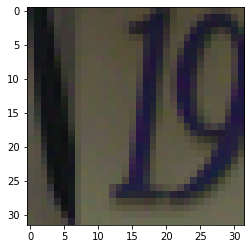

In [ ]:
# Load the dataset
X_train = loadmat('/content/gdrive/MyDrive/MDC - Trabalhos/INF - 0618-010 Deep Learning/Trabalho 3/train_32x32.mat')['X']

X_train = np.moveaxis(X_train, -1, 0)
print(X_train.shape)

plt.imshow(X_train[0])


In [ ]:
# Ajuste do dado de treino
batch_size = 64
X_train = X_train / 127.5 - 1.
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

# 1. Vanilla GAN com o SVHN
A rede mostrada na prática 8 gerava os dígitos do MNIST utilizando camadas densas. Apesar de também conter dígitos, o SVHN possui imagens maiores (32x32), e 3 canais (RGB). Essas diferenças fazem com que a rede precise ser levemente adaptada para poder trabalhar com o novo dataset e gerar novas amostras.

Portanto, altere o código da prática 8 para gerar dados do dataset SVHN com as camadas Densas da 'Vanilla' GAN, e mostre os resultados. A 'Vanilla' GAN conseguiu gerar as imagens do (mais complexo) dataset SVHN?


In [ ]:
# A primeira adaptação necessária é a alteração do tamanho da imagem para corresponder com a dimensão do SVHN
img_shape = (32, 32, 3)
latent_dim = 100

In [ ]:
# Na definição do Gerador e Discriminador não foram necessárias alterações, portanto o código é o mesmo da Aula 8

def build_generator(latent_dim, img_shape):
  model = Sequential()
  model.add(layers.Dense(256, input_dim=latent_dim))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.Dense(512))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.Dense(1024))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.Dense(np.prod(img_shape), activation='tanh'))
  model.add(layers.Reshape(img_shape))

  noise = layers.Input(shape=(latent_dim,))
  img = model(noise)
  
  return Model(noise, img)

def build_discriminator(img_shape):
  model = Sequential()
  model.add(layers.Flatten(input_shape=img_shape))
  model.add(layers.Dense(512))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dense(256))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dense(1, activation='sigmoid'))

  img = layers.Input(shape=img_shape)
  validity = model(img)

  return Model(img, validity)

In [ ]:
# Foram implementadas alterações para a geração de imagens: alterou-se os canais utilizados no imgshow para corresponder ao 3 canais RGB
def sample_images(iter, generator):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,:]) # Alteração para incluir os 3 canais RGB
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

In [ ]:
# Código abaixo é o mesmo da Aula 8

optimizer = Adam(0.0002, 0.5)

discriminator = build_discriminator(img_shape)
discriminator.summary()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

generator = build_generator(latent_dim, img_shape)

z = layers.Input(shape=(latent_dim,))
img = generator(z)

discriminator.trainable = False

validity = discriminator(img)

combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
print(combined.summary())

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 sequential_20 (Sequential)  (None, 1)                 1704961   
                                                                 
Total params: 1,704,961
Trainable params: 1,704,961
Non-trainable params: 0
_________________________________________________________________
Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 100)]             0         
                                                                 
 model_29 (Functional)       (None, 32, 32, 3)         3838720   
                                                                 
 model_28 (Functional)       (

0 [D loss: 0.803587, acc.: 26.56%] [G loss: 0.726750]


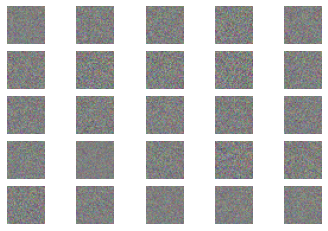

1000 [D loss: 0.513817, acc.: 78.91%] [G loss: 1.386069]


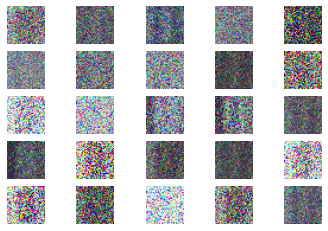

2000 [D loss: 0.579747, acc.: 70.31%] [G loss: 1.742026]


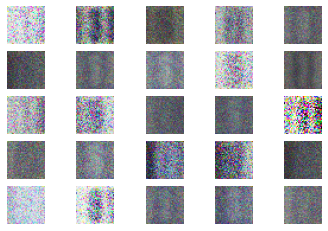

3000 [D loss: 0.567801, acc.: 73.44%] [G loss: 0.921165]


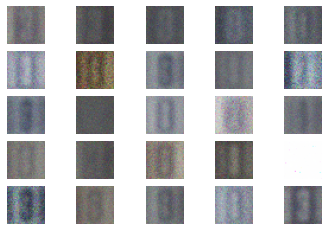

4000 [D loss: 0.553127, acc.: 74.22%] [G loss: 1.130615]


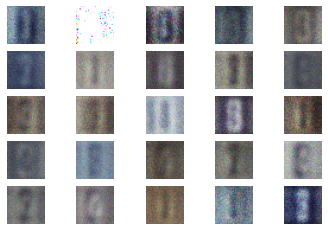

5000 [D loss: 0.492137, acc.: 71.88%] [G loss: 2.599507]


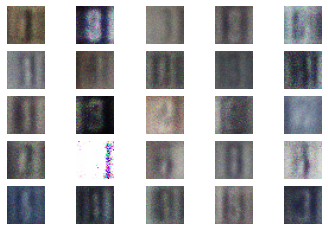

6000 [D loss: 0.491273, acc.: 76.56%] [G loss: 1.538811]


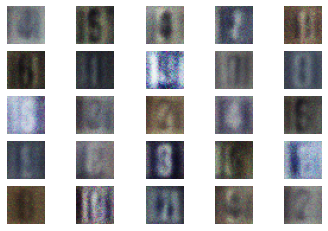

7000 [D loss: 0.522974, acc.: 72.66%] [G loss: 1.294684]


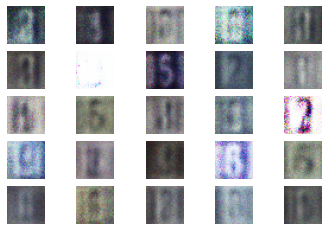

8000 [D loss: 0.526345, acc.: 71.09%] [G loss: 1.400426]


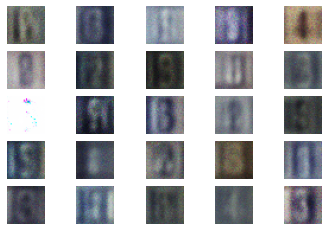

In [ ]:
# Código abaixo é o mesmo da Aula 8
iterations=9000
sample_interval=1000

for iter in range(iterations):

 
  idx = np.random.choice(X_train.shape[0], batch_size, replace=False)
  imgs = X_train[idx]

  noise = np.random.normal(0, 1, (batch_size, latent_dim))

  gen_imgs = generator.predict(noise)

  d_loss_real = discriminator.train_on_batch(imgs, valid)
  d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

  noise = np.random.normal(0, 1, (batch_size, latent_dim))

  g_loss = combined.train_on_batch(noise, valid)

  if iter % sample_interval == 0:
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iter, d_loss[0], 100*d_loss[1], g_loss))
      sample_images(iter, generator)

**Conclusão**: Avaliando os dados gerados pela GAN Vanilla, observa-se que a rede foi capaz de gerar dígitos consideravelmente convincentes tendo em vista o número de iterações realizado. As imagens possuem muito ruído ainda, mas a percepção de certos dígitos foi capaz de ser feita. Também é notável a evolução da rede, que saiu de imagens praticamente aleatórias para números simples.

Um ponto interessante é que a rede capturou bem os números 9, 8, 3 e 0. Isso pode ser atribuído ao fato deles possuírem uma estrutura similar.

Talvez com mais iterações ou uma arquitetura mais robusta a geração de dígitos pode ser feita de maneira mais performática. Algumas imagens geradas podem ser conferidas abaixo:

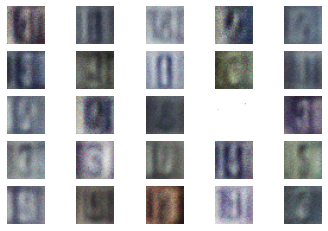

In [ ]:
sample_images(42,generator)

# Arquitetura DCGAN

Defina aqui a arquitetura do gerador e discriminador da DCGAN seguindo o modelo segundo a imagem abaixo:

<img src='https://i.imgur.com/eU2XOxS.png' />

Vamos utilizá-la para gerar os dígitos do SVHN.

In [ ]:
def build_generator_dcgan(latent_dim, img_shape):

  model = Sequential(
    [ 
      layers.Dense(128*8*8, input_dim=latent_dim),
      layers.LeakyReLU(alpha=0),
      layers.Reshape((8,8,128)),
      layers.UpSampling2D(size= (2,2)),
      layers.Conv2D(128, (3,3), padding = 'same', strides = 1),
      layers.BatchNormalization(momentum=0.8),
      layers.LeakyReLU(alpha=0),
      layers.UpSampling2D(size= (2,2)),
      layers.Conv2D(64, (3,3), padding = 'same', strides = 1),
      layers.BatchNormalization(momentum=0.8),
      layers.LeakyReLU(alpha=0),
      layers.Conv2D(3, (3,3), padding = 'same', strides = 1),
      layers.Activation('tanh')
    ]
  )

  #model.summary()

  noise = layers.Input(shape=(latent_dim,))
  img = model(noise)

  return Model(noise, img)

def build_discriminator_dcgan(img_shape):

  model = Sequential(
    [
     layers.Conv2D(32, (3,3), padding = 'same', strides = 1),
     layers.LeakyReLU(alpha=0.2),
     layers.Dropout(0.25),
     layers.Conv2D(64, (3,3), padding = 'same', strides = 1),
     layers.LeakyReLU(alpha=0.2),
     layers.Dropout(0.25),
     layers.Conv2D(128, (3,3), padding = 'same', strides = 1),
     layers.LeakyReLU(alpha=0.2),
     layers.Dropout(0.25),
     layers.Conv2D(256, (3,3), padding = 'same', strides = 1),
     layers.LeakyReLU(alpha=0.2),
     layers.Dropout(0.25),
     layers.Flatten(),
     layers.Dense(1, activation = 'sigmoid')
    ]
  )

  #model.summary()

  img = layers.Input(shape=img_shape)
  validity = model(img)

  return Model(img, validity)

# Treine a DCGAN!

Dica: Estude o código mostrado em sala na prática 8, e adapte-o para treinar a DCGAN.

In [ ]:
optimizer = Adam(0.0002, 0.5)

# Construção e compile do discriminador:
discriminator_dcgan = build_discriminator_dcgan(img_shape)
discriminator_dcgan.summary()
discriminator_dcgan.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

Model: "model_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 sequential_33 (Sequential)  (None, 1)                 650561    
                                                                 
Total params: 650,561
Trainable params: 650,561
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Construção do gerador
generator_dcgan = build_generator_dcgan(latent_dim, img_shape)
z = layers.Input(shape=(latent_dim,))
img = generator_dcgan(z)

In [ ]:
# Treinando apenas o gerador no modelo combinado
discriminator_dcgan.trainable = False

validity_dcgan = discriminator_dcgan(img)

# Instanciando o modelo combinado
combined = Model(z, validity_dcgan)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
print(combined.summary())

Model: "model_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_50 (InputLayer)       [(None, 100)]             0         
                                                                 
 model_43 (Functional)       (None, 32, 32, 3)         1051267   
                                                                 
 model_42 (Functional)       (None, 1)                 650561    
                                                                 
Total params: 1,701,828
Trainable params: 1,050,883
Non-trainable params: 650,945
_________________________________________________________________
None


0 [D loss: 0.715930, acc.: 36.72%] [G loss: 0.177312]


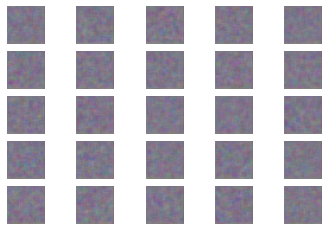

1000 [D loss: 0.598915, acc.: 67.19%] [G loss: 1.221071]


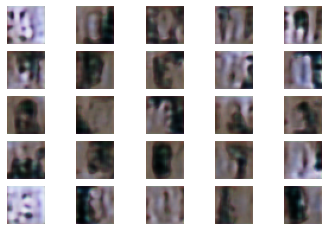

2000 [D loss: 0.572317, acc.: 75.78%] [G loss: 1.015060]


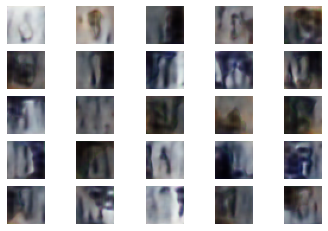

3000 [D loss: 0.712350, acc.: 48.44%] [G loss: 0.938803]


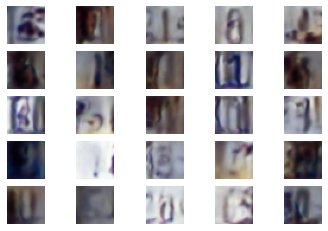

4000 [D loss: 0.587055, acc.: 67.97%] [G loss: 1.071075]


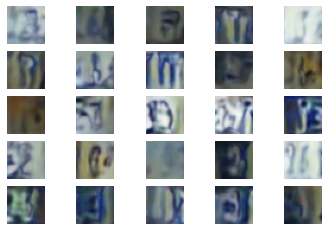

5000 [D loss: 0.681845, acc.: 57.81%] [G loss: 1.072404]


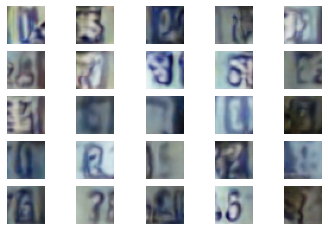

6000 [D loss: 0.618940, acc.: 67.97%] [G loss: 1.225204]


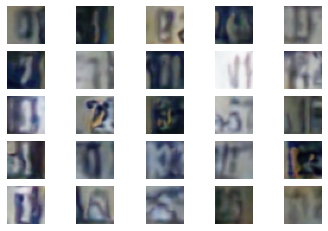

7000 [D loss: 0.538306, acc.: 75.78%] [G loss: 1.429259]


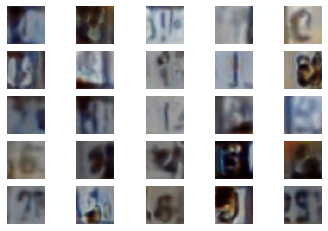

8000 [D loss: 0.554738, acc.: 67.97%] [G loss: 1.102734]


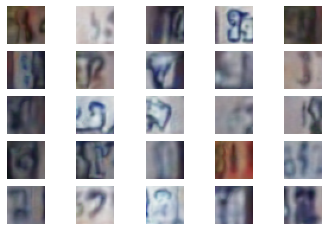

In [ ]:
iterations=9000
sample_interval=1000

for iter in range(iterations):

  # ---------------------
  #  Treino do Discriminador
  # ---------------------

  # Selecione um batch aleatório de imagens
  idx = np.random.choice(X_train.shape[0], batch_size, replace=False)
  imgs = X_train[idx]

  noise = np.random.normal(0, 1, (batch_size, latent_dim))

  # Gere um batch de imagens sintéticas.
  gen_imgs = generator_dcgan.predict(noise)

  # Treine o discriminador:
  #    Com imagens reais
  d_loss_real = discriminator_dcgan.train_on_batch(imgs, valid)
  #    Com imagens sintéticas:
  d_loss_fake = discriminator_dcgan.train_on_batch(gen_imgs, fake)
  # Faça a média das duas.
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

  # ---------------------
  #  Treino do Gerador
  # ---------------------

  # Amostragem de um ruído aleatório
  noise = np.random.normal(0, 1, (batch_size, latent_dim))

  # Treine o gerador, de forma a enganar o discriminador (tentar fazer que ele as classifique as imagens geradas como reais -> passamos 'valid' como ground truth). 
  # Por esse motivo "congelamos" os pesos do discriminador para esse passo!!!
  g_loss = combined.train_on_batch(noise, valid)

  # Plote o progresso a cada 'sample_interval' iterações
  if iter % sample_interval == 0:
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iter, d_loss[0], 100*d_loss[1], g_loss))
      sample_images(iter, generator_dcgan)

**Conclusão**: Avaliando os dados gerados pela DCGAN, observa-se que diferentemente da GAN Vanilla, a rede apresentou certa dificuldade em gerar dígitos reconhecíveis com o mesmo número de iterações (9000). Talvez, por se tratar de um modelo mais complexo, sejam necessárias mais iterações para realmente obter-se resultados satisfatórios.

Portanto, nas imagens geradas observa-se uma deficiência de forma no geral, ou seja, os números gerados não fazem muito sentido. Isso se constrasta com a GAN Vanilla em que alguns números eram possíveis de serem reconhecidos mas havia muito ruído. Outro ponto é a deficiência da rede em gerar números com mais de um dígito.

Da mesma forma que com a GAN Vanilla, nota-se que a rede gerou os números mais circulares (8,3,9,0, ...) de maneira mais convincente. Algumas imagens geradas podem ser conferidas abaixo:

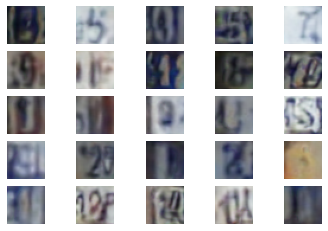

In [ ]:
sample_images(42,generator_dcgan)

## Conclusão Geral

Como conclusão final, observa-se que para o dataset proposto a GAN Vanilla talvez seja a melhor opção. Para o mesmo número de iterações ela foi capaz de capturar melhor a essência de como gerar um número, mesmo que com muito ruído. A DCGAN, mais complexa, para o número de iterações de 9000 ainda não foi capaz de gerar números reconhecíveis. Isso pode ser comprovado pelo fato das imagens geradas não terem uma forma muito estabelecida, diferentemente da GAN Vanilla em que aparentemente o maior desafio era o ruído das imagens.

Em ambas as redes também, notou-se um avanço considerável a cada 1000 iterações. Portanto, acredita-se que um maior número de iterações, por volta de 50k a 100k seja interessante para obter resultados mais realistas.